**Table of contents**<a id='toc0_'></a>    
- [Обработка естественного языка](#toc1_)    
- [Импорт библиотек](#toc2_)    
- [Импорт данных и осмотр](#toc3_)    
- [Подготовка](#toc4_)    
- [Обучение моделей](#toc5_)    
- [Сравнительный анализ моделей (без BERT) и тест лучшей](#toc6_)    
- [BERT](#toc7_)    
- [Выводы](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Обработка естественного языка](#toc0_)

**Описание процесса**

<p><img style="float:right; margin:20px; padding:20px; max-height:400px" src="https://i.postimg.cc/7ZzW68rx/7e1944af-a15d-4fed-8d18-4e5cef46d274.jpg"></p>
<p style="text-align:justify;">

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 



**Цель**

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок. Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Задачи**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.
Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Выбранный подход к решению**

1. Загружу и осмотрю данные.
2. Далее проект состоит из двух частей
3. Первая часть - создание моделей логистической регрессии, случайного леса, градиентного бустинга (catboost). Кросс-валидацию при поиске моделей не делаю из-за скорости.
    1. Подготовка текста: лемматизация (spacy), очистка от не английских букв, векторизация (TF-IDF)
    2. Обучение моделей, сбор метрик
    3. Сравнение моделей
    4. Выбор лучшей модели и обучение на полных данных с кросс-валидацией, тестирование

4. Вторая часть - использование модели BERT
    1. Найти уже обученные модели (обычная BERT и toxic_bert)
    2. Подготовить скрипт для созданния эмбеддинга
    3. Протестировать модели
5. Выводы

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# <a id='toc2_'></a>[Импорт библиотек](#toc0_)

<font color='orange' font size=4>**Установки для google colab или kaggle**</font>

In [1]:
!pip install -q catboost transformers tqdm nltk wordcloud spacy

<font color='orange' font size=4>**Импорт библиотек**</font>

In [2]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Catboost
from catboost import CatBoostClassifier

# Time
import time

# Torch
import torch
import transformers as ppb

# tqdm
from tqdm import notebook
from tqdm.notebook import tqdm

# RE
import re

# Wordcloud и другое
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests
from io import BytesIO
import random
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Spacy
import spacy
!python -q -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

2023-05-20 07:09:28.361889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# <a id='toc3_'></a>[Импорт данных и осмотр](#toc0_)

<font color='orange' font size=4>**Импорт данных**</font>

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

<font color='orange' font size=4>**Осмотр данных**</font>

In [4]:
data.shape

(159292, 3)

In [5]:
data.dtypes

Unnamed: 0     int64
text          object
toxic          int64
dtype: object

In [6]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data['toxic'].unique()

array([0, 1])

In [9]:
data['toxic'].mean()*100

10.161213369158526

In [10]:
pd.set_option('display.max_colwidth', 200)
display(data.head())

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [11]:
print(data['text'][32])

Praise 

looked at this article about 6 months ago -much improved. ]


<font color='orange' font size=5>**Вывод**</font>
1. Размер данных ~160k объектов, 2 столбца - текст (object) и целевой признак (int)
2. Целевой признак обозначен только как 1 или 0
3. 10% токсичных комментариев
4. Пропусков нет
5. Дубликатов нет
6. Тексты имеют даты, не имеющие значения символы, слова-ссылки, служебные слова вроде REDIRECT
7. Вероятно датасет был очищен от имен пользователей которые начинались с @, но @ иногда встречается


# <a id='toc4_'></a>[Подготовка](#toc0_)

<font color='orange' font size=4>**Функция для подготовки текста при помощи spaCy**</font>

In [12]:
def lemm_and_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]'," ", text)
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text

<font color='orange' font size=4>**Обратобка всех текстов в столбец 'lemm_text'**</font>

In [13]:
tqdm.pandas()
tqdm._instances.clear()
data['lemm_text'] = data['text'].progress_apply(lemm_and_clean)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
display(data[['text', 'lemm_text']][0:5])

,text,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalisms just closure on some gas after I vote at new york dolls fac and please don t remove t...
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",d aww he match this background colour I m seemingly stuck with thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the for...
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying...
4,"You, sir, are my hero. Any chance you remember what page that's on?",you sir be my hero any chance you remember what page that s on


<font color='orange' font size=4>**Облако слов для токсичных и не токсичных комментариев**</font> 

описано тут https://github.com/amueller/word_cloud/blob/main/examples/a_new_hope.py

ниже фунция для создания wordcloud

In [15]:
stop_words = text.ENGLISH_STOP_WORDS

def make_wordcloud(values):
    comment_words = ''
    # Обработка слов
    for val in notebook.tqdm(values):
        # typecaste each val to string
        val = str(val)
        # split the value
        tokens = val.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
    
    # Маска для картинки
    mask = np.array(Image.open(requests.get('https://1000logos.net/wp-content/uploads/2021/04/Twitter-logo.png', stream=True).raw))
    mask2 = np.zeros_like(mask)
    mask2[np.where(mask > 0)] = 0
    mask2[np.where(mask == 0)] = 255
    
    # Создание облака слов
    wc = WordCloud(max_words=100, mask=mask2, stopwords=stop_words, margin=10).generate(comment_words)
    
    # Вывод изображения
    default_colors = wc.to_array()
    plt.figure(figsize = (10,10))
    plt.imshow(default_colors, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return None

  0%|          | 0/159292 [00:00<?, ?it/s]

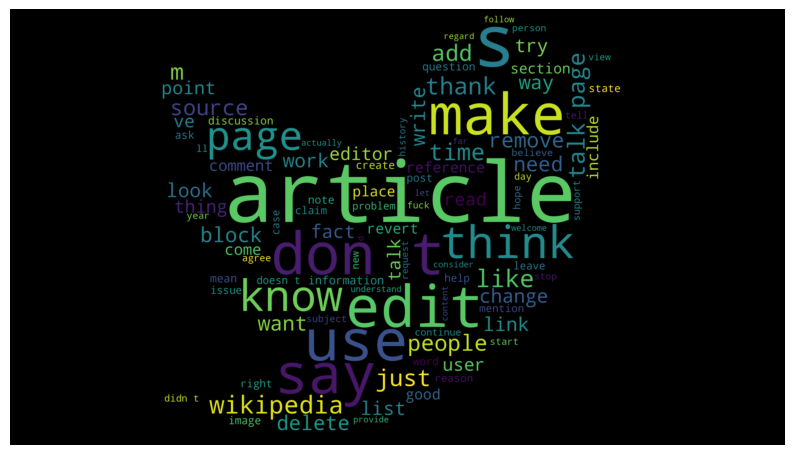

In [16]:
make_wordcloud(data['lemm_text'])

  0%|          | 0/16186 [00:00<?, ?it/s]

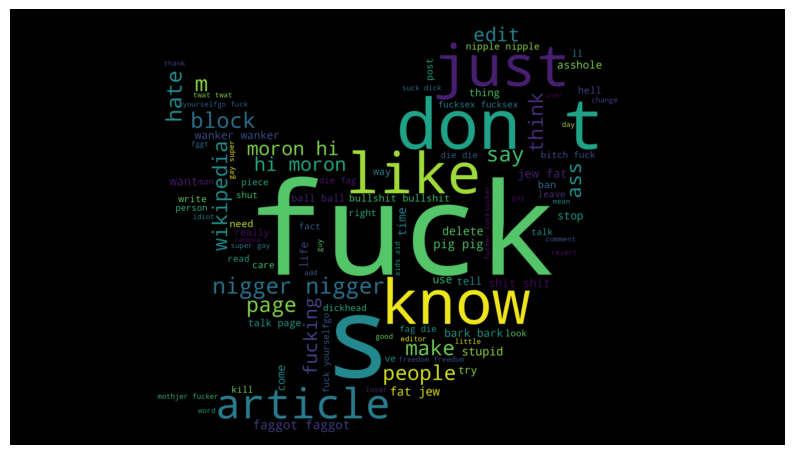

In [17]:
make_wordcloud(data['lemm_text'][data['toxic']==1])

<font color='orange' font size=4>**Деление датасета на обучающую, валидационную и тестовую выборки**</font>

In [18]:
train_and_valid, test = train_test_split(data, random_state=1, test_size=0.1, stratify=data['toxic'])
train, valid = train_test_split(train_and_valid, random_state=1, test_size=0.1, stratify=train_and_valid['toxic'])

In [19]:
X_train = train['lemm_text']
X_valid = valid['lemm_text']
X_test = test['lemm_text']
X = train_and_valid['lemm_text']

y_train = train['toxic']
y_valid = valid['toxic']
y_test = test['toxic']
y = train_and_valid['toxic']

<font color='orange' font size=4>**Векторизация текстов (TF-IDF) и удаление стоп-слов**</font>

In [20]:
count_tf_idf = TfidfVectorizer(stop_words='english')
X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)
X_valid = count_tf_idf.transform(X_valid)
X = count_tf_idf.transform(X)

# <a id='toc5_'></a>[Обучение моделей](#toc0_)

<font color='orange' font size=4>**Функция для обучения моделей и сохранения метрик**</font>

In [21]:
results = {}

def model_eval(model_name, model):

    # Обучаю модель, предсказываю, считаю вероятности для положительного класса, считаю время на обучение
    start_time_fit = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time_fit
    y_valid_predict = model.predict(X_valid)
    probabilities_test = model.predict_proba(X_valid)
    probabilities_one_test = probabilities_test[:, 1]

    # Считаю метрики
    score = model.score(X_valid, y_valid)
    roc_auc = roc_auc_score(y_valid, probabilities_one_test)
    precision = precision_score(y_valid, y_valid_predict)
    recall = recall_score(y_valid, y_valid_predict)
    f1 = f1_score(y_valid, y_valid_predict)
    # Время предсказания
    start_time = time.time()
    model.predict(X_valid)
    predict_time = time.time() - start_time

    # Вывожу
    print('Метрики')
    print('score =', score)
    print('auc_roc =', roc_auc)
    print('precision =', precision)
    print('recall =', recall)
    print('F1=', f1)

    # Сохраняю метрики
    results[model_name] = [f1, score, roc_auc, precision, recall, predict_time, train_time]
    """
    # Строю ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_test)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()

    # Строю PR-кривую
    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_test[:, 1])
    plt.figure(figsize=(4, 4))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 
    """
    return None

<font color='orange' font size=4>**Модель логистической регрессии**</font>

In [22]:
model_eval('LogisticRegression', LogisticRegression(random_state=1, verbose=0, class_weight='balanced'))

Метрики
score = 0.9426658296714794
auc_roc = 0.9727998162650215
precision = 0.6700589180503481
recall = 0.8586135895676047
F1= 0.7527075812274368


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<font color='orange' font size=4>**Модель случайного леса**</font>

In [23]:
model_eval('RandomForestClassifier', RandomForestClassifier(random_state=1, class_weight='balanced'))

Метрики
score = 0.9430145776661785
auc_roc = 0.9557772607715164
precision = 0.91343669250646
recall = 0.4852436513383665
F1= 0.6337965038099507


<font color='orange' font size=4>**Модель Catboost**</font>

In [24]:
model_eval('CatBoostClassifier', CatBoostClassifier(random_state=1, verbose=100))

Learning rate set to 0.082071
0:	learn: 0.6088976	total: 3.55s	remaining: 59m 6s
100:	learn: 0.1708181	total: 3m 12s	remaining: 28m 36s
200:	learn: 0.1491604	total: 6m 18s	remaining: 25m 6s
300:	learn: 0.1367387	total: 9m 23s	remaining: 21m 48s
400:	learn: 0.1283390	total: 12m 31s	remaining: 18m 43s
500:	learn: 0.1220127	total: 15m 38s	remaining: 15m 34s
600:	learn: 0.1174870	total: 18m 43s	remaining: 12m 26s
700:	learn: 0.1136060	total: 21m 51s	remaining: 9m 19s
800:	learn: 0.1099898	total: 24m 58s	remaining: 6m 12s
900:	learn: 0.1066064	total: 28m 1s	remaining: 3m 4s
999:	learn: 0.1036563	total: 31m 1s	remaining: 0us
Метрики
score = 0.9561972518658017
auc_roc = 0.9637097307067616
precision = 0.8877455565949486
recall = 0.6513383665065202
F1= 0.7513855898653999


# <a id='toc6_'></a>[Сравнительный анализ моделей (без BERT) и тест лучшей](#toc0_)

In [25]:
df_results = pd.DataFrame(results, index=['f1', 'score', 'roc_auc', 'precision', 'recall', 'time_predict', 'time_train'])
display(df_results)

,LogisticRegression,RandomForestClassifier,CatBoostClassifier
f1,0.752708,0.633797,0.751386
score,0.942666,0.943015,0.956197
roc_auc,0.972800,0.955777,0.963710
precision,0.670059,0.913437,0.887746
recall,0.858614,0.485244,0.651338
time_predict,0.006366,1.623438,0.266077
time_train,10.042206,745.292190,1898.985023


<font color='orange' font size=4>**Выбрал модель логистической регрессии**</font>

In [26]:
from sklearn.model_selection import GridSearchCV
params = {'C': [0.1, 0.5, 1, 5, 10, 15, 20]}
model = GridSearchCV(LogisticRegression(), params)
model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 15, 20]})

In [27]:
y_test_predict = model.predict(X_test)
f1 = f1_score(y_test, y_test_predict)
print(f1)

0.786254295532646


<font color='orange' font size=4>**Выводы**</font>

- Логистическая регрессия хорошо себя показала, по всем метрикам
- Случайный лес не подходит для этой задачи, особенно по метрикам f1 и времени
- Кэтбуст близок к логистической регрессии, но есть огромный минус - время обучения
- Вероятно кэтбуст можно еще улучшить, а вот у логистической регрессии шансов на улучшение мало (кроме другого ядра и регуляризации)

# <a id='toc7_'></a>[BERT](#toc0_)

Будет две модели BERT - DistilBertModel и Toxic-BERT

<font color='orange' font size=4>**Подготовка данных для BERT**</font>

Удаляю лишние знаки и привожу к нижнему регистру

In [28]:
def clean_text_for_bert(text):
    
    # Привожу все буквы к нижнему регистру
    text = text.lower()
    # Убираю лишнее
    text = re.sub(r'[^a-z.,!?\n]'," ", text)
    return text

In [29]:
data['for_bert'] = data['text'].progress_apply(clean_text_for_bert)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [30]:
display(data[['text', 'for_bert']][0:3])

,text,for_bert
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...","explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren t vandalisms, just closure on some gas after i voted at new york dolls fac. and please don t remo..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)","d aww! he matches this background colour i m seemingly stuck with. thanks. talk , january , utc"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...","hey man, i m really not trying to edit war. it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about..."


In [31]:
data_for_bert = pd.DataFrame({'text_bert' : data['for_bert'], 'target' : data['toxic']})

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="5"><b>ВАЖНАЯ ЧАСТЬ!</b></font>
   
Выбираю размер данных для берт
    
</div>

In [32]:
data_for_bert = data_for_bert.sample(n=50000, random_state=1)

<font color='orange' font size=4>**DistilBertModel**</font>

https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

In [33]:
# Выбираю модель
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Загружаю готовую модель
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<font color='orange' font size=4>**Токенизация и создание маски**</font>

In [34]:
tokenized = data_for_bert['text_bert'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [35]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print('padded = ', np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print('attention_mask = ', attention_mask.shape)

padded =  (50000, 512)
attention_mask =  (50000, 512)


<font color='orange' font size=4>**Создание эмбеддингов**</font>

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [37]:
embeddings = []
batch_size = 100

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

<font color='orange' font size=4>**Деление данных для BERT**</font>

In [38]:
features = np.concatenate(embeddings)
labels = data_for_bert['target']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<font color='orange' font size=4>**Обучение и тест модели DistilBertModel**</font>

In [39]:
model = LogisticRegression()
model.fit(train_features, train_labels)
preds = model.predict(test_features)
print(f1_score(test_labels, preds))

0.7405821917808219


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<font color='orange' font size=4>**Модель BERT для определения сентимента unitary/toxic-bert**</font>

Модель взята с сайта hugging-face

In [40]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
model = AutoModel.from_pretrained("unitary/toxic-bert")

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<font color='orange' font size=4>**Токенизация и создание маски**</font>

In [41]:
tokenized = data_for_bert['text_bert'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

  0%|          | 0/50000 [00:00<?, ?it/s]

(50000, 512)

<font color='orange' font size=4>**Создание эмбеддингов**</font>

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [43]:
embeddings = []
batch_size = 100

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

<font color='orange' font size=4>**Деление данных для BERT**</font>

In [44]:
features = np.concatenate(embeddings)
labels = data_for_bert['target']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<font color='orange' font size=4>**Обучение и тест модели toxic-bert**</font>

In [45]:
model = LogisticRegression()
model.fit(train_features, train_labels)
preds = model.predict(test_features)
print(f1_score(test_labels, preds))

0.9306381292112564


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# <a id='toc8_'></a>[Выводы](#toc0_)

- Цель достигнута при логистической регрессии на TF-IDF (f1 score = 0.78), так и на Toxic-BERT (f1 score = 0.93)
- Предобученная BERT для цели анализа тональности - подходит очень хорошо
- BERT без специализации прогнозирует примерно также, как и линейная регрессия с данными TF-IDF
- Использование BERT требует значительных мощностей (GPU обязательно)